In [1]:
import datetime as dt
import pickle
from typing import NoReturn, Optional

import pandas as pd
import numpy as np
from pyod.models.knn import KNN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:144: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
xl = pd.ExcelFile('PS Transactions.xlsx')
xl.sheet_names

['Method 1', 'Method 2', 'Method 3', 'Method 4', 'Method 5']

> В файле «Payment System Transactions» находится информация о прохождении платежей по 6-ти платежным методам. Данные для различных платежных методов находятся на отдельных вкладках.

Странно, но здесь только 5 вкладок

In [3]:
for x in xl.sheet_names:
    print(xl.parse(x).shape)

(225960, 2)
(426, 2)
(659, 2)
(99361, 2)
(5916, 2)


# Method 1

In [4]:
df1 = xl.parse('Method 1', index_col='dt')
df1.head()

,amount
dt,
2015-08-01 00:00:00,272.712437
2015-08-01 00:00:03,226.121284
2015-08-01 00:00:11,229.449223
2015-08-01 00:00:12,226.121284
2015-08-01 00:00:28,239.433042


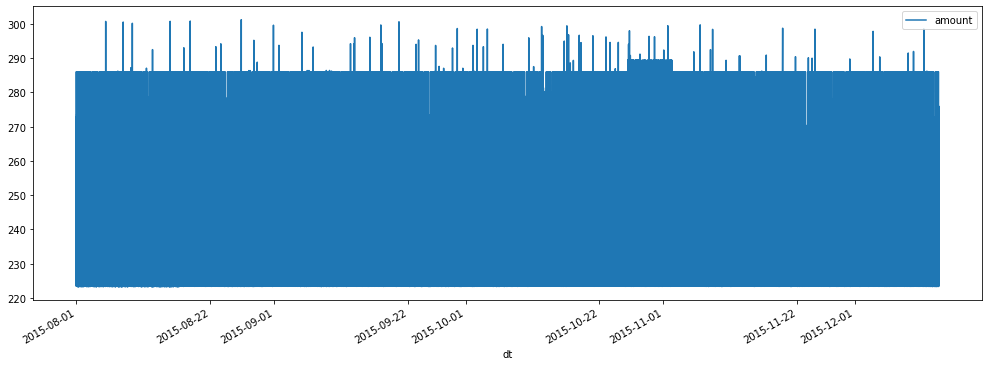

In [5]:
# Возможно это не самый красивый график, зато достаточно показательный:
# Хорошо заметны выбросы, как в положительную сторону, так и в отрицательную

df1.plot(figsize=(17, 6));

Выбросы вниз могут быть связаны как раз со сбоем платёжной системы. С выбросами вверх - не совсем понятно: это может быть как и технической проблемой, так и пользователи вдруг решили хорошенько закупиться, ну или случайно добавили один нолик в конце. В любом случае, для более точного понимания проблемы, всё же нужно вникнуть в предметную область и поговорить с экспертом в этой теме, чтобы точно понимать значения этих выбросов.

Еще стоит посмотреть на задержку, между платежами, думаю, она тоже будет достаточно информативной.

In [6]:
def plot_delay(df: pd.DataFrame, limit: Optional[pd.Timedelta] = None, column: Optional[str] = None) -> NoReturn:
    plt.figure(figsize=(17, 8))
    plt.plot(df['diff'].dropna().apply(lambda x: np.timedelta64(x).astype('float')/1000000))
    if limit:
        plt.axhline(
            y=np.timedelta64(limit).astype('float')/1000000,
            color='r', linestyle='-', label='Верхняя граница выбросов'
        )
    
    if column:
        plt.plot(df[df[column] != 0]['diff'].apply(lambda x: np.timedelta64(x).astype('float')/1000000), alpha=0.6, color='red', label=column)
    plt.title('Задержка между транзакциями', fontsize=16)
    plt.ylabel('Задержка, sec')
    plt.grid(True, axis='y', alpha=0.5, linestyle='--')
    if column or limit:
        plt.legend()
    plt.show()

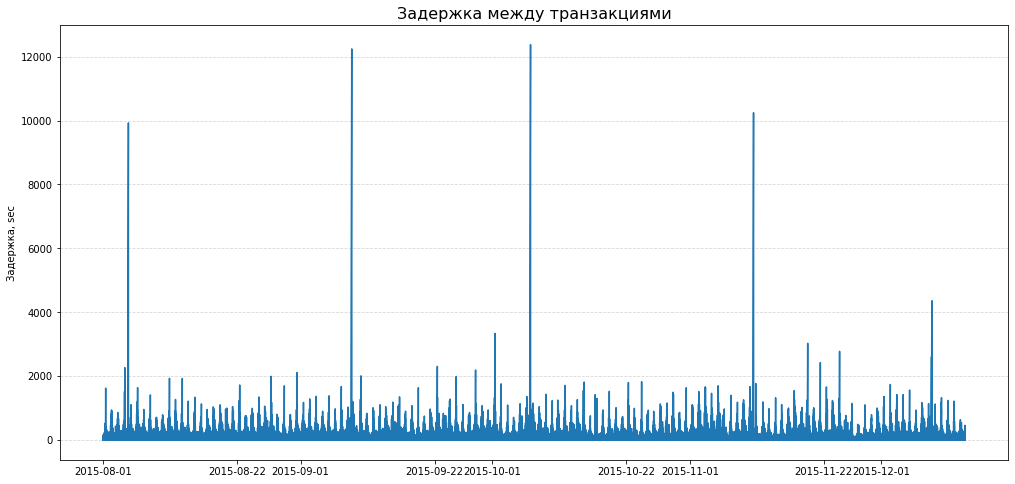

In [7]:
df1['diff'] = df1.index.to_series().diff(1)
plot_delay(df1)

Этот график оказался более информативным и более логичным: если у нас большая задержка между покупками, то это скорее всего и есть сбой системы, думаю лучшим вариантом будет классифицировать неполадку относительно разницы во времени между покупками.Для начала посмотрим статистики:

In [8]:
df1['diff'].describe()  # Ого, 3 часа задержки, вот, наверное, недовольных много было :)

count                    225959
mean     0 days 00:00:51.683455
std      0 days 00:01:36.434165
min             0 days 00:00:00
25%             0 days 00:00:10
50%             0 days 00:00:26
75%             0 days 00:01:00
max             0 days 03:26:15
Name: diff, dtype: object

Для оценки наших данных будем использовать медиану, т.к. она является робастной характеристикой. Чтобы находить выбросы, существую много разных способов, простейшие способы основаны на межквартильном расстоянии:

In [9]:
def find_outlier(df: pd.DataFrame, coef: int = 3) -> pd.Timedelta:
    """Outlier detection with interquartile distance."""

    df = df.dropna()
    
    # Calculate statistics:
    median = df['diff'].median()
    Q1 = df['diff'].quantile(0.25)
    Q3 = df['diff'].quantile(0.75)
    
    # External_borders:
    interquartile_range = Q3 - Q1
    limit = Q3 + interquartile_range * coef
    
    print(f'Количество выбросов на всём датасете: {len(df[df["diff"] > limit])}')
    return limit

Межквартальный диапазон умножается на некий коэффициент, для нахождения значительных выбросов обычно выбирается коэффициент, равный 3:

In [10]:
coef = 3
find_outlier(df1.copy(), coef)

Количество выбросов на всём датасете: 8184


Timedelta('0 days 00:03:30')

Однако можно заметить, что при таком коэффициенте, у нас слишком много выбросов: 8184. Да и задержка в 3 с половиной минуты кажется не такой уж критичной. Безусловно, можно пойти к специалисту и узнать у него, какую задержку стоит классифицировать как сбой в системе, но, опять же, у меня такой возможности, к сожалению нет. Мне показалось, что адекватные значения получаются при коэффициенте равным 20:

Количество выбросов на всём датасете: 149
Limit: 0 days 00:17:40


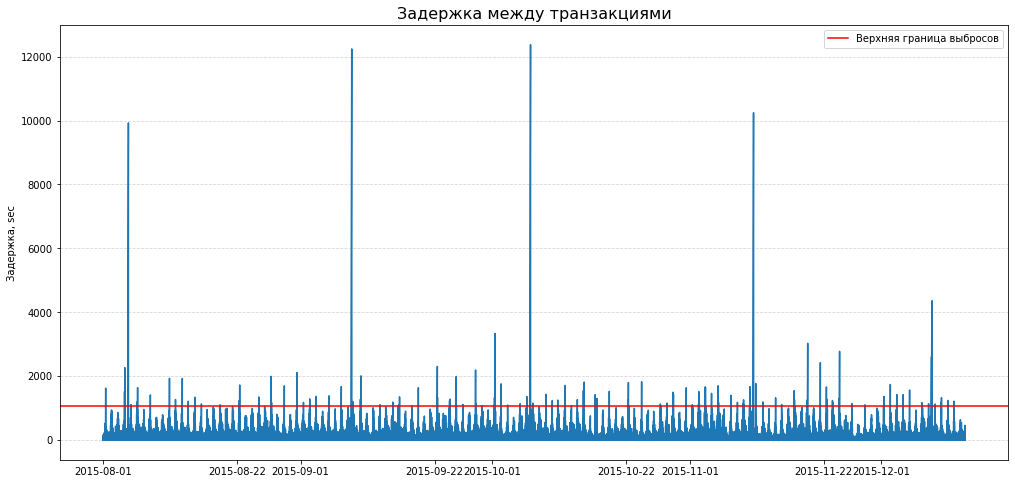

In [11]:
coef = 20
limit_1 = find_outlier(df1.copy(), coef)
print(f'Limit: {limit_1}')  # Без знания предметной области, мне кажется, что 17 минут простоя между платежами уже существенно
plot_delay(df1, limit_1)

Мы также можем попробовать другой алгоритм для нахождения аномалий, например knn:

In [12]:
clf = KNN(contamination=0.2, n_neighbors=2, radius=0.7)
clf.fit(df1["diff"].dropna().values.reshape(-1, 1))
arr = clf.decision_function(df1["diff"].dropna().values.reshape(-1, 1))

with open('clf_method_1.pickle', 'wb') as handle:
    pickle.dump(clf, handle)  

print(f'Количество выбросов = {len(arr[arr != 0])}')

Количество выбросов = 274


Опять же, в этом алгоритме тоже можно по разному варьировать количество ближайших соседей (чем их больше, чем больше выбросов у нас найдётся и наоборот) и относительно этого менять количество выбросов.
Попробуем визуализировать наши выбросы:

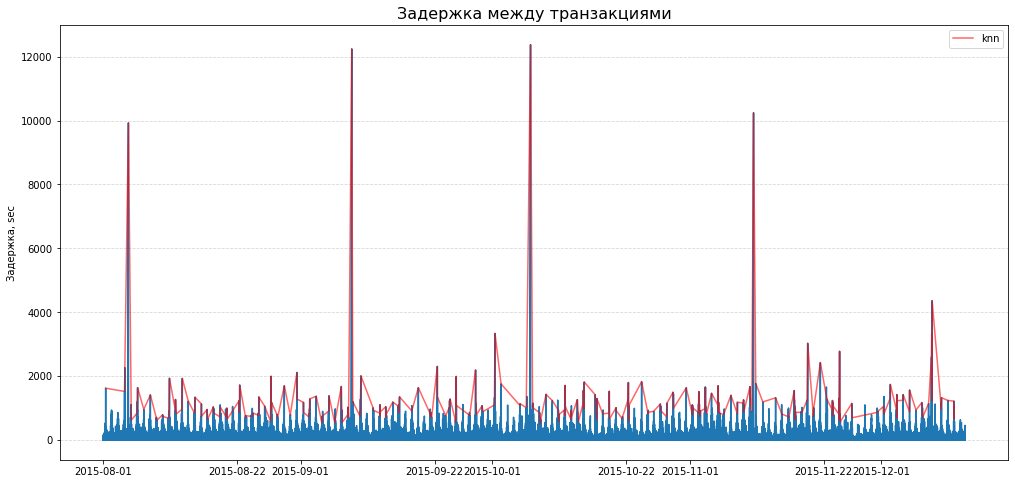

In [13]:
df1['knn'] = np.concatenate([[0], arr])
plot_delay(df1, column='knn')

Мы можем использовать и другие алгоритмы для нахождения выбросов, например, основанные на нейронных сетях (AutoEncoder), на деревьях (IsolationForest) или более тонкие методы, например, критерий Шовене или критерий Пирса. Однако, примерная суть остаётся неизменная - всё равно нужен специалист со стороны, который укажет примерную границу задержки в поступлении денег, при превышения которой будут отправлять оповещения.

# Method 2

In [14]:
df2 = xl.parse('Method 2', index_col='dt')
print(df2.shape)
df2.head()

(426, 1)


,amount
dt,
2015-08-01 01:35:35,230.780399
2015-08-01 02:35:53,226.094660
2015-08-01 14:15:45,242.627865
2015-08-02 11:25:06,232.644045
2015-08-02 13:25:32,230.114811


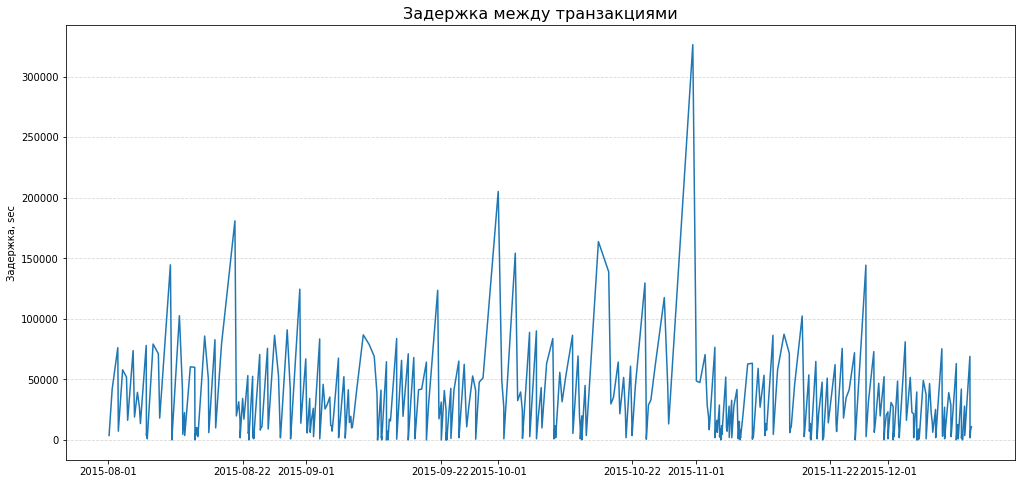

In [15]:
df2['diff'] = df2.index.to_series().diff(1)
plot_delay(df2)

Данных теперь на 3 порядка меньше и KNN уже хуже справляется с работой:

In [16]:
clf = KNN(contamination=0.5, n_neighbors=2, p=1)
clf.fit(df2["diff"].dropna().values.reshape(-1, 1))
arr = clf.decision_function(df2["diff"].dropna().values.reshape(-1, 1))

print(f'Количество выбросов = {len(arr[arr != 0])}')

Количество выбросов = 358


Зато хорошо работает метод, основанный на межквартильном расстоянии: 

Количество выбросов на всём датасете: 4
Limit: 1 days 19:39:04


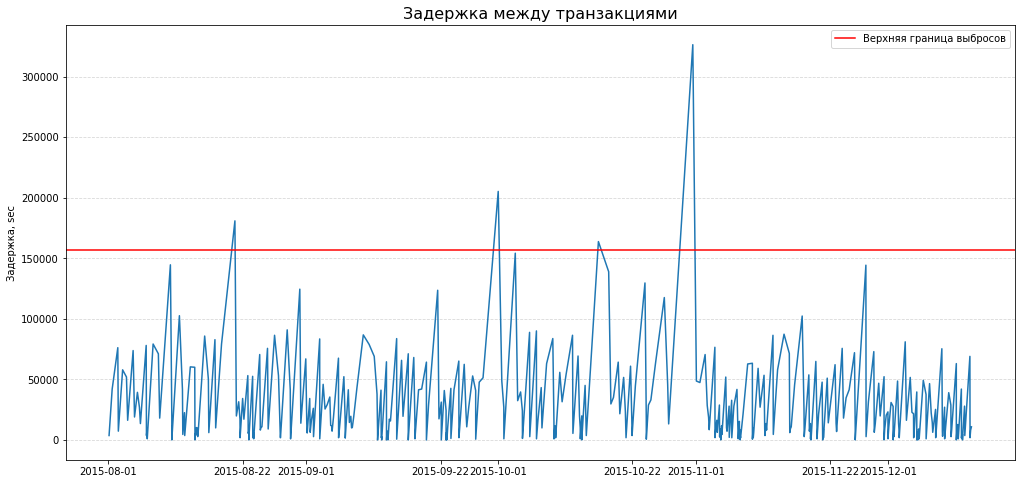

In [17]:
coef = 3
limit_2 = find_outlier(df2.copy(), coef)
print(f'Limit: {limit_2}')
plot_delay(df2, limit_2)

# Method 3

In [18]:
df3 = xl.parse('Method 3', index_col='dt')

print(df3.shape)
display(df3.head())

(659, 1)


,amount
dt,
2015-08-01 02:05:33,245.356774
2015-08-01 02:09:11,258.002945
2015-08-01 02:37:01,232.777163
2015-08-01 06:24:27,232.644045
2015-08-01 16:53:29,231.179752


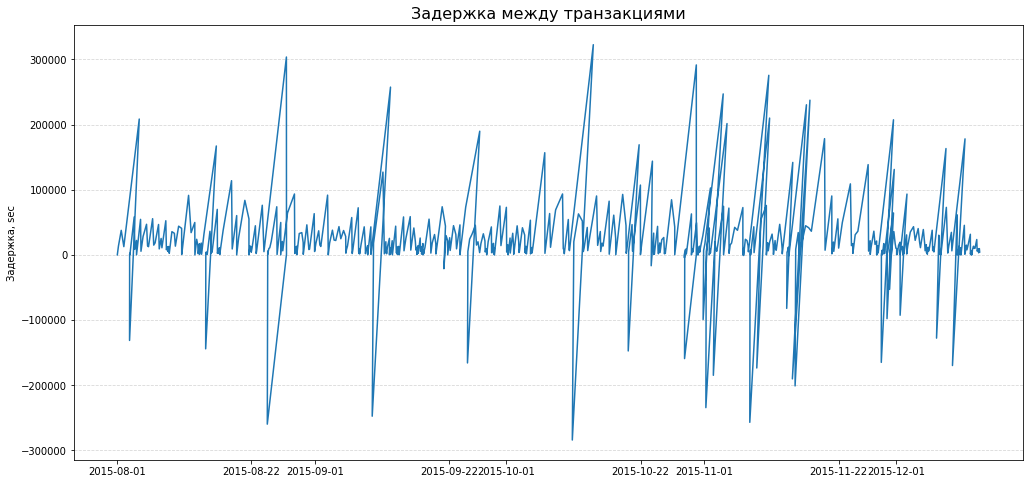

In [19]:
df3['diff'] = df3.index.to_series().diff(1)
plot_delay(df3)

У нас появились отрицательные задержки, видимо данные не отсортированы, исправим это:

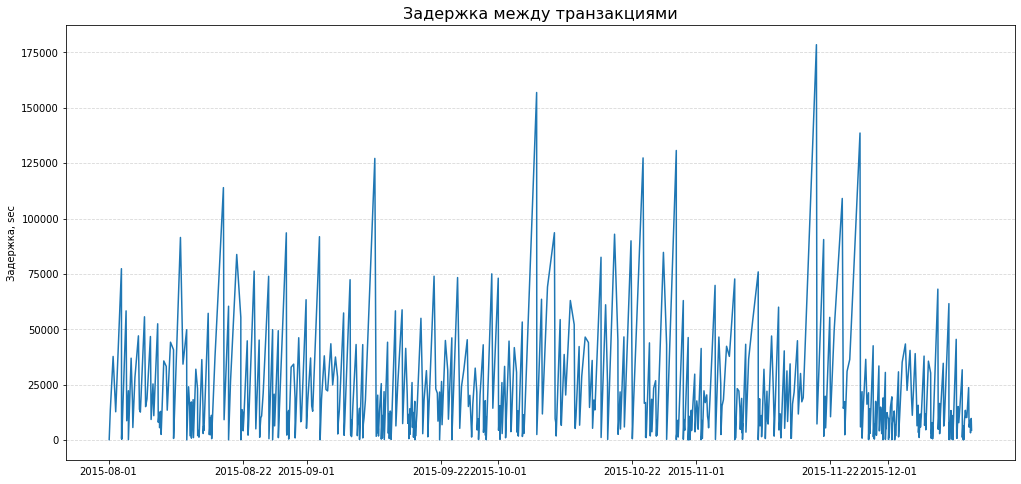

In [20]:
df3 = df3.sort_index()
df3['diff'] = df3.index.to_series().diff(1)
plot_delay(df3)

Т.к. данных опять мало, попробуем обычную статистику:

Количество выбросов на всём датасете: 18
Limit: 0 days 22:15:41.750000


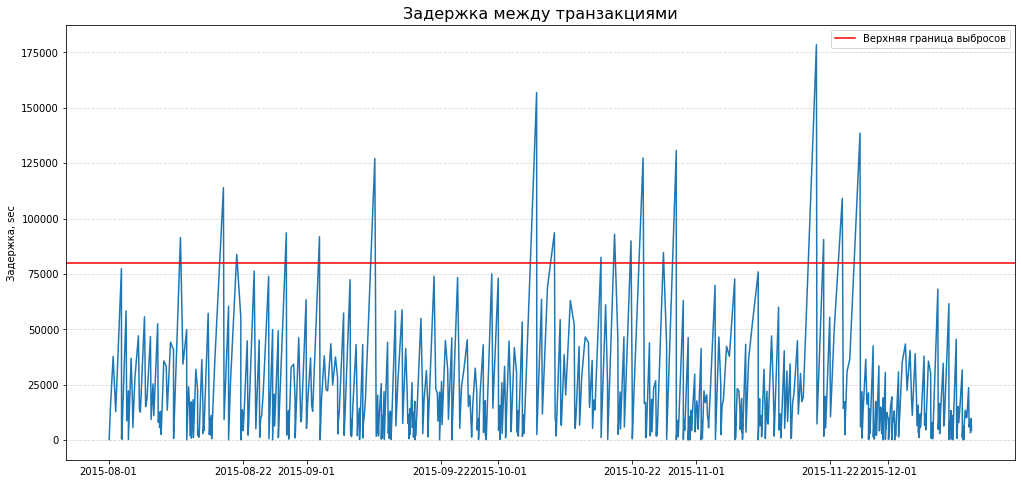

In [21]:
coef = 3
limit_3 = find_outlier(df3.copy(), coef)
print(f'Limit: {limit_3}')
plot_delay(df3, limit_3)

# Method 4

In [22]:
df4 = xl.parse('Method 4', index_col='dt')

print(df4.shape)
display(df4.head())

(99361, 1)


,amount
dt,
2015-08-01 00:00:38,226.121284
2015-08-01 00:00:48,229.449223
2015-08-01 00:01:40,223.458932
2015-08-01 00:02:14,229.449223
2015-08-01 00:04:34,229.449223


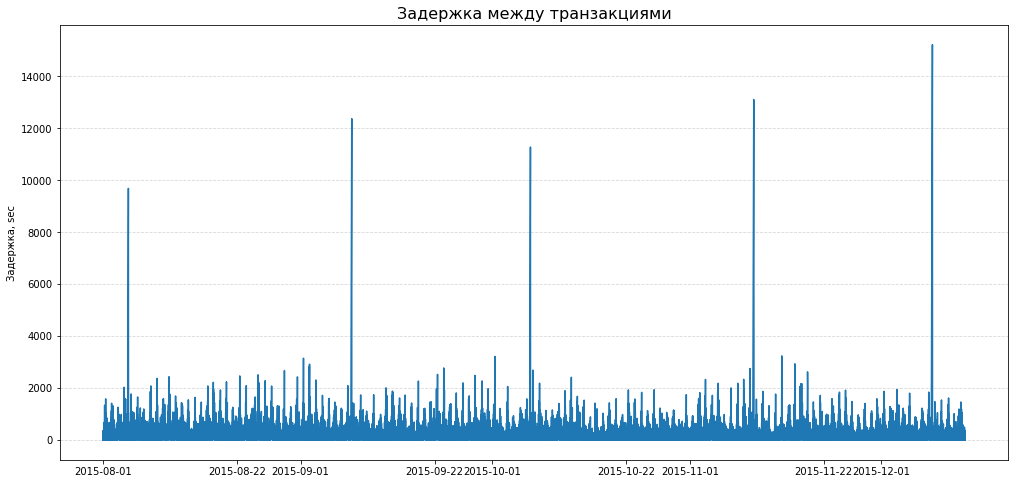

In [23]:
df4['diff'] = df4.index.to_series().diff(1)
plot_delay(df4)

In [24]:
clf = KNN(contamination=0.4, n_neighbors=2, radius=0.5, method='median', leaf_size=16)
clf.fit(df4["diff"].dropna().values.reshape(-1, 1))
arr = clf.decision_function(df4["diff"].dropna().values.reshape(-1, 1))

with open('clf_method_4.pickle', 'wb') as handle:
    pickle.dump(clf, handle)  

print(f'Количество выбросов = {len(arr[arr != 0])}')

Количество выбросов = 357


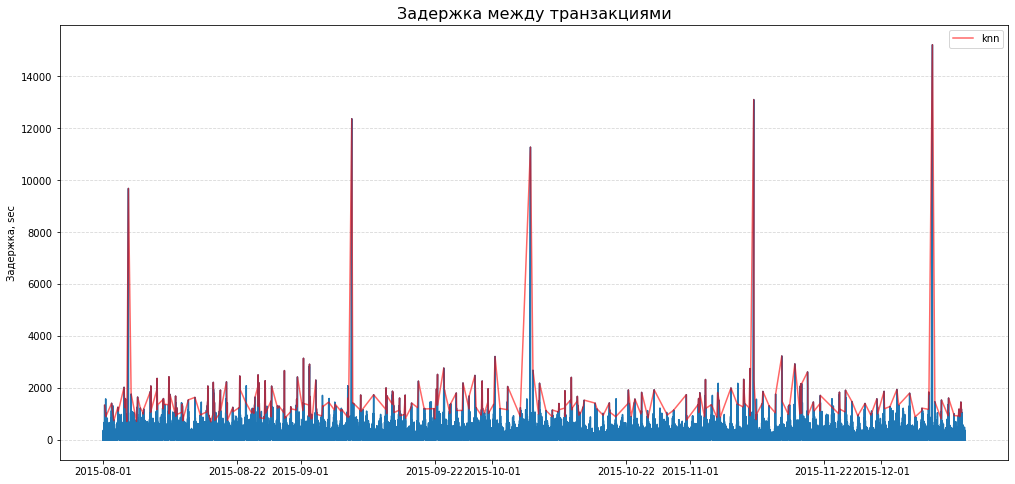

In [25]:
df4['knn'] = np.concatenate([[0], arr])
plot_delay(df4, column='knn')

# Method 5

In [26]:
df5 = xl.parse('Method 5', index_col='dt')

print(df5.shape)
display(df5.head())

(5916, 1)


,amount
dt,
2015-08-01 00:12:04,238.101866
2015-08-01 00:14:54,232.644045
2015-08-01 00:24:17,242.627865
2015-08-01 00:31:28,229.449223
2015-08-01 00:46:50,232.644045


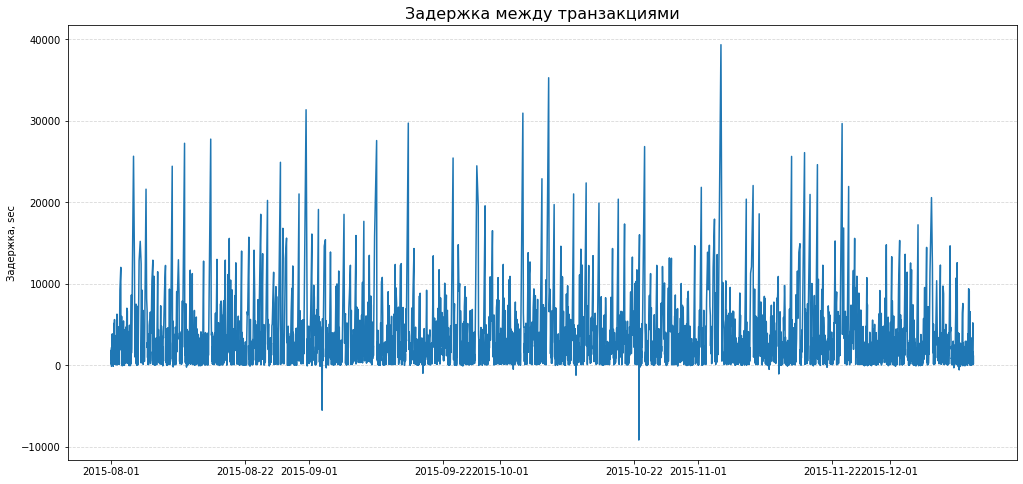

In [27]:
df5['diff'] = df5.index.to_series().diff(1)
plot_delay(df5)

Опять есть неотсортированные индексы. Исправляем:

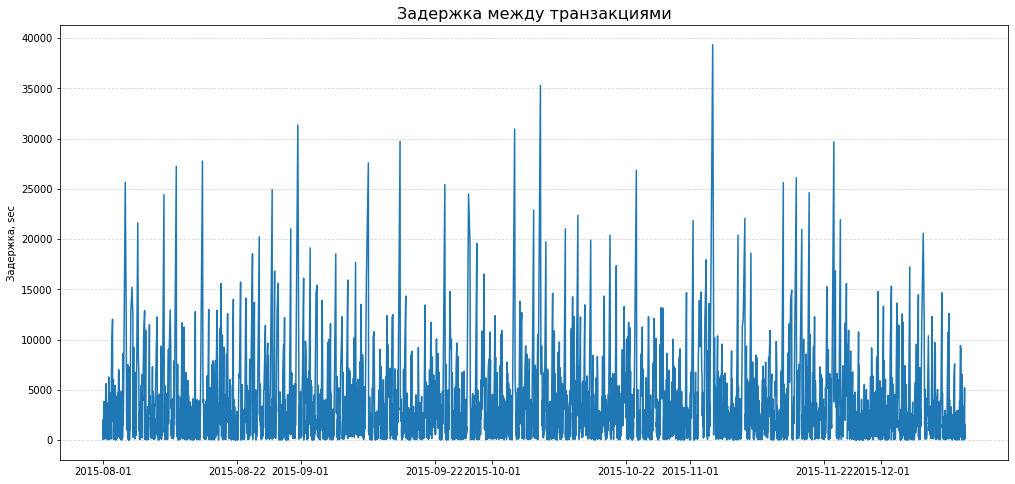

In [28]:
df5 = df5.sort_index()
df5['diff'] = df5.index.to_series().diff(1)
plot_delay(df5)

Количество выбросов на всём датасете: 27
Limit: 0 days 05:43:32


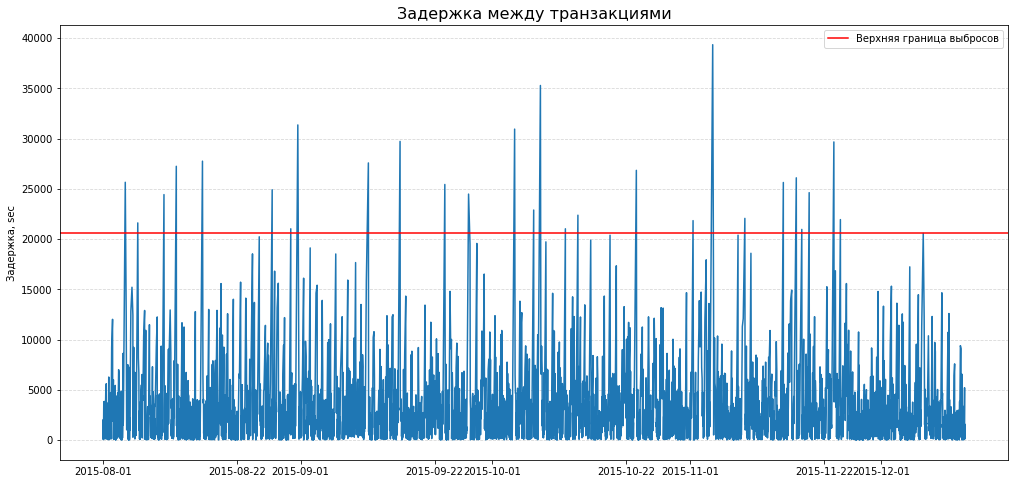

In [29]:
coef = 9
limit_5 = find_outlier(df5.copy(), coef)
print(f'Limit: {limit_5}')
plot_delay(df5, limit_5)

Сначала небольшие выводы:

Классический метод, основанный на межквартильном расстоянии работает достаточно хорошо на небольших данных. Однако на больших, ведёт себя намного хуже - при стандартном коэффициенте выдаёт много выбросов. Что касается алгоритма KNN, он, наоборот, хорошо работает на более высокочастотных платежах и хуже на менее частотных. Но и он не без изъянов и, как мне кажется, порой частенько ошибается, опять же, выдавая большее количество, чем есть на самом деле.

Однако, уж лучше у нас будет ошибка 1 рода, чем ошибка 2 рода. Простыми словами, лучше если специалисту будут дополнительно поступать "возможные" технические сбои.

В заключении, если бы я использовал модель на проде, то поставил для каждого метода свой порог времени задержки, относительного которого мы бы классифицировали ошибку. А порог я ставил бы на основании статистических анализов и мнения эксперта в этой области.

Сам алгоритм:

In [30]:
class ProblemFinder:
    def __init__(
        self,
        path_to_clf_1: str,
        limit_2: pd.Timedelta,
        limit_3: pd.Timedelta,
        path_to_clf_4,
        limit_5: pd.Timedelta
    ):
        self.limits = {
            2: limit_2,
            3: limit_3,
            5: limit_5
        }
        self.clfs = {
            1: self.read_pickle(path_to_clf_1),
            4: self.read_pickle(path_to_clf_4)
        }
        
    @staticmethod
    def read_pickle(path: str):
        with open(path, 'rb') as handle:
            smt = pickle.load(handle)
        return smt

    def notify(self, method_number: int):
        print(f'NOTIFY {method_number}')

    def check(self, delay: pd.Timedelta, method_number: int) -> NoReturn:
        """
        Check if such delay is a failure in the payment system.
        And send a notification if necessary.

        Parameters
        ----------
        delay : pd.Timedelta
            Delay between last payment and current time.
        method_number : {1, 2, 3, 4, 5} int
            Payment method number to verify.

        """
        if method_number in self.limits.keys():
            if delay > self.limits[method_number]:
                self.notify(method_number)
        elif method_number in self.clfs.keys():
            delay_ = pd.Series(delay).values.reshape(-1, 1)
            if self.clfs[method_number].decision_function(delay_)[0] != 0:
                self.notify(method_number)
        else:
            raise ValueError('`method_number` must be an integer in the range [1, 2, 3, 4, 5]')

### Usage example:

In [31]:
PF = ProblemFinder('clf_method_1.pickle', limit_2, limit_3, 'clf_method_4.pickle', limit_5)

#### For limits:

In [32]:
# limit_5 = '0 days 05:43:32'

check_limit = pd.Timedelta('0 days 06:43:32')  # outlier
PF.check(check_limit, 5)

NOTIFY 5


In [33]:
check_limit = pd.Timedelta('0 days 04:43:32')  # not outlier
PF.check(check_limit, 5)

#### For clf:

In [34]:
check_limit = pd.Timedelta('0 days 01:03:01')  # outlier
PF.check(check_limit, 4)

NOTIFY 4


In [35]:
check_limit = pd.Timedelta('0 days 00:13:01')  # not outlier
PF.check(check_limit, 4)